## Googleドライブにアクセスする

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 場所を移動する

マイドライブの中の「展開演習2」に移動

In [2]:
%cd /content/drive/MyDrive/展開演習２/

/content/drive/MyDrive/展開演習２


## ライブラリのインポート

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import transforms
import torchvision.models as models

from tqdm.auto import tqdm   # プログレスバーを表示

## 画像処理の定義

transforms.CenterCrop(image_size)
と
transforms.ToTensor()
の間に，様々な画像処理を足すと良い（データ拡張という）

例：

* transforms.RandomHorizontalFlip(),  # ランダムに左右反転
* transforms.RandomVerticalFlip(),    # ランダムに上下反転
* transforms.RandomRotation(10),      # ランダムに回転(数字が角度)
* transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5), # 色調の変更
* transforms.RandomEqualize(), # ランダムにヒストグラムを平坦化

など

In [47]:
image_size = 224

class ImageTransform():
    def __init__(self, mean=0.5, std=0.5):
        self.data_transform = transforms.Compose([
                transforms.Resize(image_size),      # リサイズ
                transforms.CenterCrop(image_size),  # 画像中心で切り抜く
                transforms.RandomHorizontalFlip(),  # ランダムに左右反転
                transforms.ToTensor(),              # テンソル化：[0, 255]を[0, 1]に
                transforms.Normalize(mean, std),    # 正規化（平均mean, 標準偏差stdにする）
                ])

    def __call__(self, img):
        return self.data_transform(img)

## データセットの読み込み

transform=ImageTransform()の部分は，デフォルト(引数なし)では，mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)が使用される．

一般的に，平均と標準偏差は次にすると良いと言われている．

mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

例：

transform=ImageTransform(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [48]:
# データセットのパス
# 今いる場所は、マイドライブ＞展開演習２
image_dir = './data2024/'

# データセットの読み込み
dataset = torchvision.datasets.ImageFolder(
    root=image_dir,
    transform=ImageTransform(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    )

print(f"データ数:{len(dataset)}")

データ数:1289


## データセットの分割

サンプルは学習:検証=7:3だが，8:2や9:1にしても良い

In [49]:
train_data_rate = 0.7   # 学習データの割合

# 学習と検証に7：3で分ける
train_size = int(train_data_rate * len(dataset))
val_size = len(dataset) - train_size

# ランダムに分ける
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

print(f"学習用データ数:{len(train_dataset)},検証用データ数:{len(val_dataset)}")

学習用データ数:902,検証用データ数:387


## データローダーの作成

バッチサイズを大きくすると，学習は安定するが学習時間がかかりメモリも大量に消費する．

もし，バッチサイズを多くしたら，エポック数（後述）は小さくしても良い．

In [50]:
batch_size = 32     # 1バッチのデータ数

# 学習用のデータローダー
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,          # データセット
    batch_size=batch_size,  # バッチサイズ
    shuffle=True,           # シャッフル：あり
)

# 検証用のデータローダー
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,           # シャッフル：なし
)

print(f"学習用バッチ数:{len(train_dataloader)},検証用バッチ数:{len(val_dataloader)}")

学習用バッチ数:29,検証用バッチ数:13


## データの確認（省略可）

データセットの読み込みで画像処理の平均と標準偏差を変更した場合は，それに合わせる．

mean=np.array([0.485, 0.456, 0.406])

std=np.array([0.229, 0.224, 0.225])

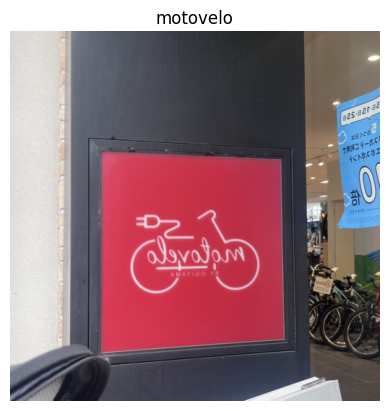

In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 平均と標準偏差
mean=np.array([0.5, 0.5, 0.5])
std=np.array([0.5, 0.5, 0.5])

# クラス名を取得
class_list = dataset.classes

# データローダーから1バッチ取り出す
for images, labels in train_dataloader:
    # 各チャネルに平均と標準偏差を適用（正規化を元に戻す）
    for i in range(3):
        images[:, i, :, :] = images[:, i, :, :] * std[i] + mean[i]
    # バッチの先頭1枚を画像に変換
    pic = transforms.ToPILImage(mode='RGB')(images[0])
    plt.imshow(pic)
    # ラベルをタイトルに表示
    label_num = labels[0].numpy()   # ラベルに取得（番号）
    plt.title(class_list[label_num])    # 名前をタイトルに表示
    plt.axis('off')      # 軸を表示しない
    plt.show()           # 表示
    break

## 公開されているモデルを読み込む

ここでは，ResNet18を例に紹介する．

違うモデルに変えた場合は，最終層のクラス数を変更する箇所は，名称がモデルごとに違うため確認すること．

In [57]:
# resnet18とその重みを読み込む
model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")

# モデル構造の確認（特に，最終層の名称を確認する）
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

上で確認した名称の最終層のクラス数を変更する

In [58]:
# パラメータを固定（転移学習する場合）
for param in model.parameters():
    param.requires_grad = False

# クラス数の取得
class_num = len(dataset.class_to_idx)
print(f"クラス数:{class_num}")

# 最終層のクラス数を変更
model.fc = nn.Linear(model.fc.in_features, class_num)

# デバイスの取得
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device : {device}')

# モデルをデバイスに移動する
model = model.to(device)

# 確認
model

クラス数:40
device : cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## モデルの学習

### 学習用の関数

In [53]:
# 学習用の関数
def train(model, device, train_loader, criterion, optimizer):
    model.train()   # モデルを訓練モードにする
    loss_train = 0.0    # 損失の初期化
    correct = 0     # 正解数
    total = 0       # 全データ数
    with tqdm(enumerate(train_loader), total=len(train_loader), desc="[train]", leave=False) as pbar_train:
        for i, (data, target) in pbar_train:
            # データをデバイスに送る
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()   # 勾配の初期化
            output = model(data)    # 予測
            loss = criterion(output, target)   # 損失の計算
            loss.backward()         # 勾配の計算
            optimizer.step()        # パラメータの更新

            loss_train += loss.item()       # 損失の蓄積
            _, predicted = output.max(1)    # 予測ラベル
            total += target.size(0)         # データ数の累積
            correct += predicted.eq(target).sum().item()    # 正解数の累積

            pbar_train.update()    # プログレスバーの更新
            # プログレスバーの最後
            pbar_train.set_postfix({"loss":loss_train/len(train_loader), "acc":correct/total})
    return loss_train/len(train_loader), correct/total

### 評価用の関数

In [54]:
# 評価用の関数
def val(model, device, val_loader, criterion):
    model.eval()    # モデルを評価モードにする
    loss_val = 0.0  # 損失の初期化
    correct = 0     # 正解数
    total = 0       # 全データ数
    with tqdm(enumerate(val_loader), total=len(val_loader), desc="[val]", leave=False) as pbar_val:
        for i, (data, target) in pbar_val:
            # データをデバイスに送る
            data, target = data.to(device), target.to(device)
            # 勾配計算はなしにする
            with torch.no_grad():
                output = model(data)    # 予測
                loss = criterion(output, target)    # 損失の計算

                loss_val += loss.item()         # 損失の蓄積
                _, predicted = output.max(1)    # 予測ラベル
                total += target.size(0)         # データ数の累積
                correct += predicted.eq(target).sum().item()    # 正解数の累積

            pbar_val.update()  # プログレスバーの更新
            # プログレスバーの最後
            pbar_val.set_postfix({"loss":loss_val/len(val_loader), "acc":correct/total})
    return loss_val/len(val_loader), correct/total

### 学習と評価

エポック数を変更する．

In [55]:
epochs = 30      # エポック数
lr = 0.001      # 学習率
criterion = torch.nn.CrossEntropyLoss()    # 損失関数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)    # 最適化アルゴリズム

losses_train = []   # 学習の損失の記録用
losses_val = []     # 評価の損失の記録用
accs_train = []     # 学習の正解率の記録用
accs_val = []       # 評価の正解率の記録用
# 各損失，正解率の初期化
loss_train, acc_train, loss_val, acc_val = 0.0, 0.0, 0.0, 0.0

with tqdm(range(epochs)) as pbar_epoch:
    for epoch in pbar_epoch:
        pbar_epoch.set_description(f"[Epoch {epoch+1}]")

        # 学習
        loss_train, acc_train = train(model, device, train_dataloader, criterion, optimizer)
        # 評価
        loss_val, acc_val = val(model, device, val_dataloader, criterion)

        # 各損失と正解率の記録
        losses_train.append(loss_train)
        losses_val.append(loss_val)
        accs_train.append(acc_train)
        accs_val.append(acc_val)

        pbar_epoch.update()    # プログレスバーの更新
        # プログレスバーの最後
        pbar_epoch.set_postfix({"loss_train":loss_train, "acc_train":acc_train,
                                "loss_val":loss_val, "acc_val":acc_val})

# モデルの保存
#（後ろの'MyOriginalModel'が保存するモデルの名前．'.pth'が拡張子）
# .to('cpu')をするのを忘れない．
# もし，GPUを使って学習していた場合，同じGPUでないと読み込むことができない．
torch.save(model.to('cpu').state_dict(), 'MyOriginalModel.pth')
print('Finished Training')

[Epoch 30]: 100%|██████████| 30/30 [48:47<00:00, 97.58s/it, loss_train=0.588, acc_train=0.946, loss_val=1.07, acc_val=0.778]

Finished Training


## グラフ出力

損失と正解率のグラフを出力する．

特に，損失のグラフを確認して，学習データ・検証データ共に下がっていれば問題ない．
もし，検証データの損失が上昇していれば，過学習となっている．
また，どちらも水平に近い形になっていなければ，学習が足りない．

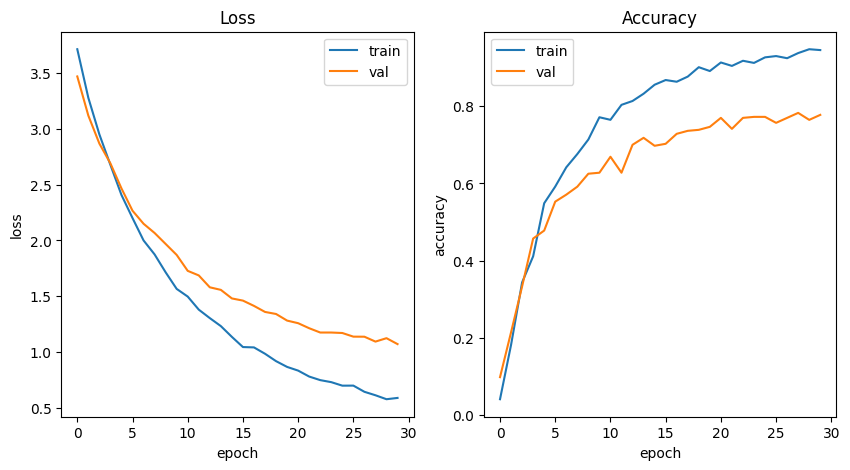

In [56]:
# グラフ
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(losses_train, label='train')
ax[0].plot(losses_val, label='val')
ax[0].set_title('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(accs_train, label='train')
ax[1].plot(accs_val, label='val')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()

plt.show()